In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

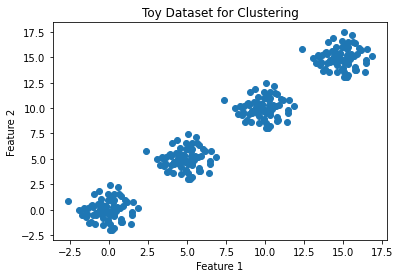

In [2]:
# Parameters for the toy dataset
n_samples = 300
random_state = 42

# Create data for 4 clusters
cluster_1 = np.random.RandomState(random_state).normal(loc=0, scale=1, size=(n_samples // 4, 2))
cluster_2 = np.random.RandomState(random_state).normal(loc=5, scale=1, size=(n_samples // 4, 2))
cluster_3 = np.random.RandomState(random_state).normal(loc=10, scale=1, size=(n_samples // 4, 2))
cluster_4 = np.random.RandomState(random_state).normal(loc=15, scale=1, size=(n_samples // 4, 2))

# Concatenate all clusters to form the dataset
data = np.concatenate((cluster_1, cluster_2, cluster_3, cluster_4))

# Plot the dataset
plt.scatter(data[:, 0], data[:, 1])
plt.title("Toy Dataset for Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [3]:
df = pd.DataFrame(data)
df.to_csv("data/data_2d.csv", index=False)

In [4]:
df = pd.read_csv("data/data_2d.csv", header=0)
assignments = pd.read_csv("final_assignments.txt", header=None, names=["labels"])

In [5]:
combined = pd.concat([df, assignments], axis=1)
combined.head()

,0,1,labels
0,0.496714,-0.138264,0
1,0.647689,1.523030,0
2,-0.234153,-0.234137,0
3,1.579213,0.767435,0
4,-0.469474,0.542560,0


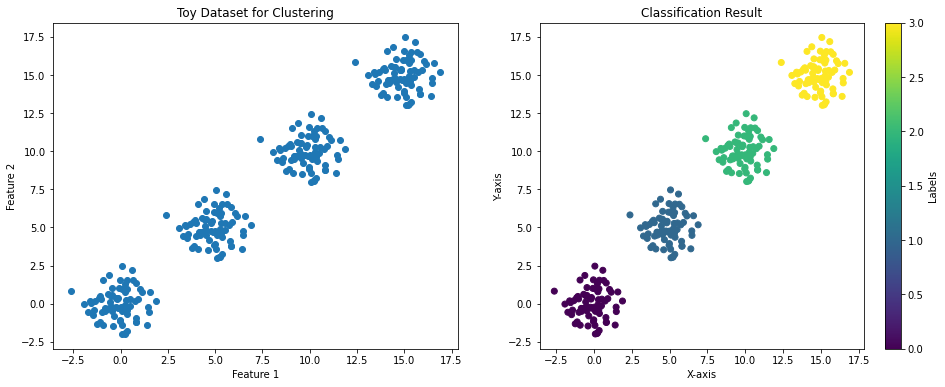

In [6]:
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
data = np.concatenate((cluster_1, cluster_2, cluster_3, cluster_4))
plt.scatter(data[:, 0], data[:, 1])
plt.title("Toy Dataset for Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1,2,2)
plt.scatter(combined['0'], combined['1'], c=combined['labels'], cmap='viridis')

# Customize the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Classification Result')
plt.colorbar(label='Labels')

# Show the plot
plt.savefig("out/2d_scatter.jpg")
plt.show()

In [11]:
# Define the range and increment
max_dim = 1000000
increment = 10

# Create a list to store meta information
meta_data = []

M=10000

# Loop through different dimensions and create datasets
while M < max_dim+1:
    N = 10
    while N < 10 + 1:
        # Create a random MxN dataset
        dataset = np.random.rand(M, N)
        
        # Define the CSV file name based on dimensions
        filename = f'dataset_{M}x{N}.csv'
        
        # Save the DataFrame as a CSV file
        df = pd.DataFrame(dataset)
        df.to_csv("data/" + filename, index=False)
        
        # Record meta information (dimension and file path)
        meta_data.append({'M': M, 'N':N, 'file_path': os.path.abspath("data/" + filename)})
        
        print(f'Dataset {M}x{N} saved as {filename}')
        N *= 10
    M *= 10

# Create a meta DataFrame
meta_df = pd.DataFrame(meta_data)

# Save the meta DataFrame as a CSV file
meta_df.to_csv('meta_dataset.csv', index=False)


Dataset 10x10 saved as dataset_10x10.csv
Dataset 10x100 saved as dataset_10x100.csv
Dataset 10x1000 saved as dataset_10x1000.csv
Dataset 10x10000 saved as dataset_10x10000.csv
Dataset 100x10 saved as dataset_100x10.csv
Dataset 100x100 saved as dataset_100x100.csv
Dataset 100x1000 saved as dataset_100x1000.csv
Dataset 100x10000 saved as dataset_100x10000.csv
Dataset 1000x10 saved as dataset_1000x10.csv
Dataset 1000x100 saved as dataset_1000x100.csv
Dataset 1000x1000 saved as dataset_1000x1000.csv
Dataset 1000x10000 saved as dataset_1000x10000.csv
Dataset 10000x10 saved as dataset_10000x10.csv
Dataset 10000x100 saved as dataset_10000x100.csv
Dataset 10000x1000 saved as dataset_10000x1000.csv
Dataset 10000x10000 saved as dataset_10000x10000.csv


In [7]:
time_df = pd.read_csv("meta_dataset.csv")
time_df.drop(columns=["file_path"], axis=1, inplace=True)
time_df.head(2)

,M,N,k,optimized,time(ms)
0,100,10,2,1,148
1,100,10,2,0,3


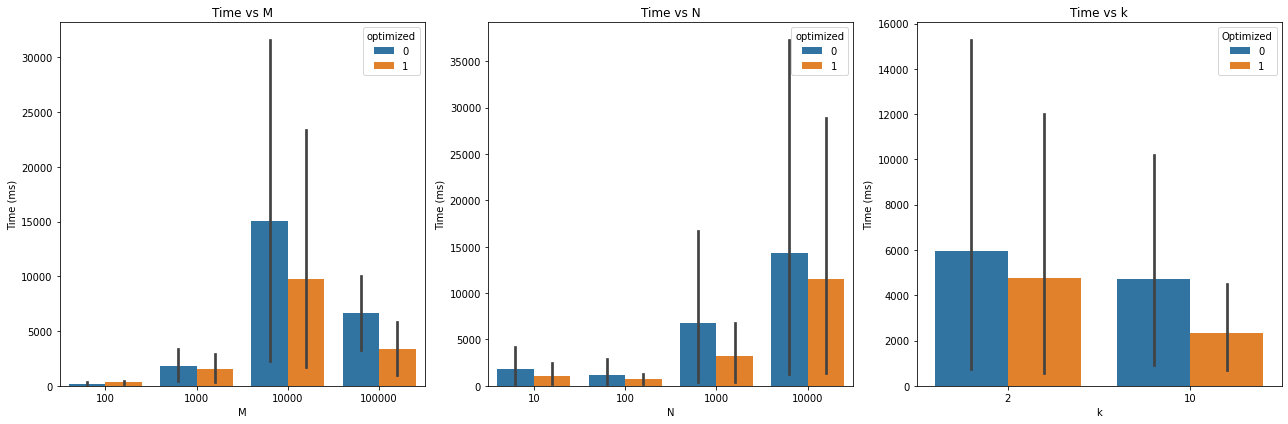

In [8]:
time_df_avg = time_df.groupby(['M', 'N', 'k', 'optimized'])['time(ms)'].mean().reset_index()

# Plotting heatmaps

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bar plot for M
sns.barplot(x='M', y='time(ms)', hue='optimized', data=time_df_avg, ax=axes[0])
axes[0].set_title('Time vs M')
axes[0].set_xlabel('M')
axes[0].set_ylabel('Time (ms)')

# Bar plot for N
sns.barplot(x='N', y='time(ms)', hue='optimized', data=time_df_avg, ax=axes[1])
axes[1].set_title('Time vs N')
axes[1].set_xlabel('N')
axes[1].set_ylabel('Time (ms)')

# Bar plot for k
sns.barplot(x='k', y='time(ms)', hue='optimized', data=time_df_avg, ax=axes[2])
axes[2].set_title('Time vs k')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Time (ms)')

plt.tight_layout()
plt.legend(title='Optimized')
plt.savefig("out/barchart.jpg")
plt.show()


# Roofline

In [8]:
def compute_ai(N, dataDimension, k, iteration):
    flops_centroid_init = 2*dataDimension*N*k*(k-1)+N
    bytes_centroid_init = 4*N*dataDimension+4*N*k
    ai_centroid_init = flops_centroid_init/bytes_centroid_init

    flops_distance_calc = iteration*(2*N*dataDimension*k + k)
    bytes_distance_calc = iteration*(4*(N+k)*dataDimension + 4*N*k)
    ai_distance_calc = flops_distance_calc/bytes_distance_calc

    flops_centroid_update = iteration*((dataDimension+1)*k)
    bytes_centroid_udpate = iteration*(2*4*k*dataDimension)
    ai_centroid_update = flops_centroid_update/bytes_centroid_udpate

    return ai_centroid_init, ai_distance_calc, ai_centroid_update

In [9]:
def compute_flops(N, dataDimension, k, iteration):
    flops_centroid_init = 2*k*dataDimension*N*(k-1)+N
    flops_distance_calc = iteration*(2*N*dataDimension*k + k)
    flops_centroid_update = iteration*((dataDimension+1)*k)

    return flops_centroid_init, flops_distance_calc, flops_centroid_update

In [10]:
roofline_df = pd.read_csv("roofline.csv")
roofline_df.head()

,N,dataDimension,k,iterations,centroid_initialization,distance_calculation,centroid_update
0,100,10,2,4,0.000020,0.000272,0.000017
1,100,10,10,13,0.000177,0.001321,0.000101
2,100,100,2,6,0.000049,0.000789,0.000187
3,100,100,10,3,0.001410,0.001570,0.000115
4,100,1000,2,2,0.000323,0.002083,0.000585


In [11]:
performance_centroid_init_l = []
performance_distance_calc_l = []
performance_centroid_update_l = []
ai_centroid_init_l = []
ai_distance_calc_l = []
ai_centroid_update_l = []
for x in roofline_df.itertuples():
    N = x.N
    dataDimension = x.dataDimension
    k = x.k
    iterations = x.iterations
    centroid_init_time = x.centroid_initialization
    distance_calculation_time = x.distance_calculation
    centroid_update_time = x.centroid_update

    ai_centroid_init, ai_distance_calc, ai_centroid_update = compute_ai(N, dataDimension, k, iterations)
    ai_centroid_init_l.append(ai_centroid_init)
    ai_distance_calc_l.append(ai_distance_calc)
    ai_centroid_update_l.append(ai_centroid_update)

    flops_centroid_init, flops_distance_calc, flops_centroid_update = compute_flops(N, dataDimension, k, iterations)
    performance_centroid_init = flops_centroid_init/centroid_init_time
    performance_distance_calc = flops_distance_calc/distance_calculation_time
    performance_centroid_update = flops_centroid_update/centroid_update_time

    performance_centroid_init_l.append(performance_centroid_init)
    performance_distance_calc_l.append(performance_distance_calc)
    performance_centroid_update_l.append(performance_centroid_update)

roofline_df["performance_centroid_init"] = performance_centroid_init_l
roofline_df["performance_distance_calc"] = performance_distance_calc_l
roofline_df["performance_centroid_update"] = performance_centroid_update_l

roofline_df["ai_centroid_init"] = ai_centroid_init_l
roofline_df["ai_distance_calc"] = ai_distance_calc_l
roofline_df["ai_centroid_update"] = ai_centroid_update_l

roofline_df.head()

,N,dataDimension,k,iterations,centroid_initialization,distance_calculation,centroid_update,performance_centroid_init,performance_distance_calc,performance_centroid_update,ai_centroid_init,ai_distance_calc,ai_centroid_update
0,100,10,2,4,0.000020,0.000272,0.000017,2.100087e+08,5.883456e+07,5.073801e+06,0.854167,0.820082,0.137500
1,100,10,10,13,0.000177,0.001321,0.000101,1.015896e+09,1.969861e+08,1.409284e+07,22.512500,2.382143,0.137500
2,100,100,2,6,0.000049,0.000789,0.000187,8.163182e+08,3.042224e+08,6.464414e+06,0.982843,0.961587,0.126250
3,100,100,10,3,0.001410,0.001570,0.000115,1.276223e+09,3.822505e+08,2.626355e+07,40.911364,4.166875,0.126250
4,100,1000,2,2,0.000323,0.002083,0.000585,1.239797e+09,3.839730e+08,6.845802e+06,0.998253,0.978478,0.125125


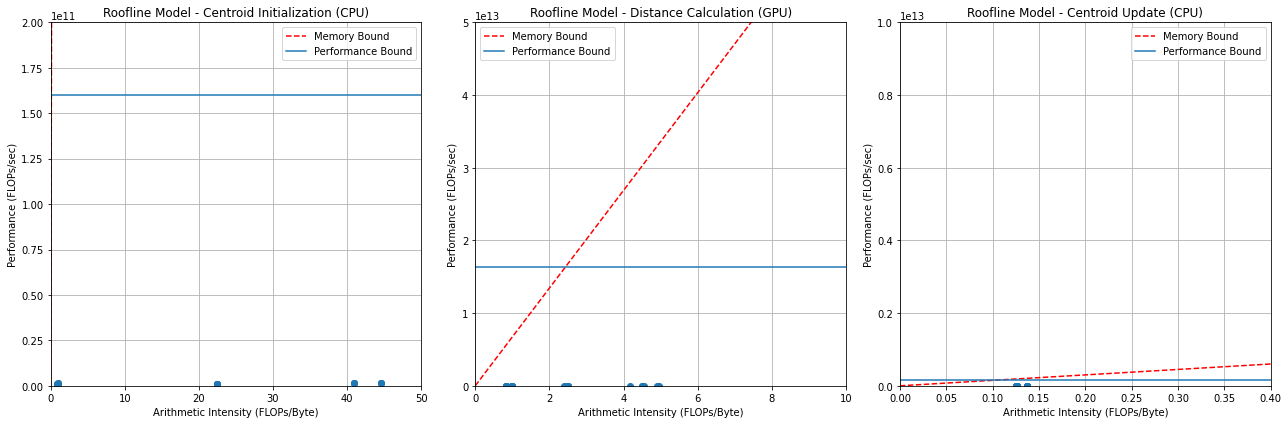

In [27]:
# Create 3 Roofline Model Graphs
B_cpu_flops = 150*10e9 #Bytes/s
B_gpu_flops = 672*10e9

peak_performance_cpu = 160 * 1e9  #FLOPs
peak_performance_gpu = 16.3 * 1e12

ai_range = roofline_df[['ai_centroid_init', 'ai_distance_calc', 'ai_centroid_update']].max().max()
ai_values = np.linspace(0, ai_range, 100)

# Calculate memory-bound performance
memory_bound_cpu = ai_values * B_cpu_flops
memory_bound_gpu = ai_values * B_gpu_flops

# Plot the Roofline Model with Memory and Compute Bounds
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Adjust X-axis range to the data graphed
max_ai_init = roofline_df['ai_centroid_init'].max()
max_ai_dist = roofline_df['ai_distance_calc'].max()
max_ai_update = roofline_df['ai_centroid_update'].max()

# Function for plotting
def plot_roofline(ax, ai_data, perf_data, memory_bound, performance_peak, title):
    ax.scatter(ai_data, perf_data)
    ax.plot(ai_values, memory_bound, 'r--', label='Memory Bound')
    ax.axhline(performance_peak, label='Performance Bound')
    ax.set_title(title)
    ax.set_xlabel('Arithmetic Intensity (FLOPs/Byte)')
    ax.set_ylabel('Performance (FLOPs/sec)')
    ax.legend()
    ax.grid(True)

# Centroid Initialization with CPU bounds
plot_roofline(axes[0], roofline_df['ai_centroid_init'], roofline_df['performance_centroid_init'], 
              memory_bound_cpu, peak_performance_cpu, 'Roofline Model - Centroid Initialization (CPU)')
axes[0].set_xlim(0, 50)
axes[0].set_ylim(0,2*1e11)

# Distance Calculation with GPU bounds
plot_roofline(axes[1], roofline_df['ai_distance_calc'], roofline_df['performance_distance_calc'], 
              memory_bound_gpu, peak_performance_gpu, 'Roofline Model - Distance Calculation (GPU)')
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0,0.5*1e14)

# Centroid Update with CPU bounds
plot_roofline(axes[2], roofline_df['ai_centroid_update'], roofline_df['performance_centroid_update'], 
              memory_bound_cpu, peak_performance_cpu, 'Roofline Model - Centroid Update (CPU)')
axes[2].set_xlim(0, 0.4)
axes[2].set_ylim(0,1*1e13)

# Display the plots
plt.tight_layout()
plt.show()